In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


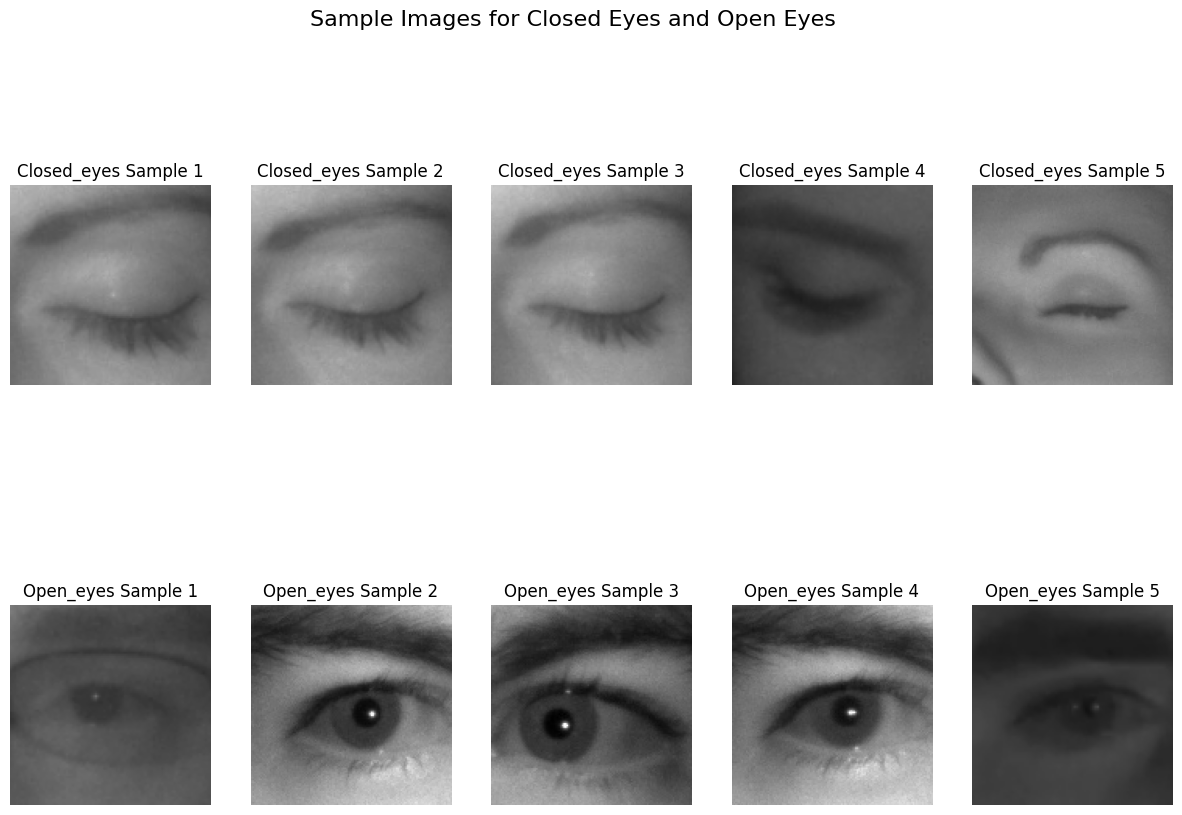

In [16]:
import os
import cv2
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define the directory paths where your images are stored
base_dir = '/content/drive/MyDrive/archive (5)/train'

# List of eye states
eye_states = ['Closed_Eyes', 'Open_Eyes']

# Display sample images for each eye state
sample_images = {eye_state: [] for eye_state in eye_states}

for eye_state in eye_states:
    eye_state_dir = os.path.join(base_dir, eye_state)
    image_files = os.listdir(eye_state_dir)

    # Display the first few images from each eye state
    for i in range(5):
        image = cv2.imread(os.path.join(eye_state_dir, image_files[i]))
        sample_images[eye_state].append(image)

# Plot sample images
plt.figure(figsize=(15, 10))
for i, eye_state in enumerate(eye_states):
    for j, image in enumerate(sample_images[eye_state]):
        plt.subplot(2, 5, i * 5 + j + 1)  # Adjusted for 2 rows, one for Closed Eyes and one for Open Eyes
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'{eye_state.capitalize()} Sample {j + 1}')
        plt.axis('off')

plt.suptitle('Sample Images for Closed Eyes and Open Eyes', fontsize=16)
plt.show()





# Initialize a LabelEncoder to encode eye states
label_encoder = LabelEncoder()

# Initialize lists to store images and corresponding labels
images = []
labels = []

# Load and preprocess images
for eye_state in eye_states:
    eye_state_dir = os.path.join(base_dir, eye_state)
    image_files = os.listdir(eye_state_dir)

    for file in image_files:
        image = cv2.imread(os.path.join(eye_state_dir, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, (128, 128))  # Resize images to a common size
        images.append(image)
        labels.append(eye_state)

# Encode the labels using label encoding
label_encoder.fit(labels)  # Fit the encoder with the labels
encoded_labels = label_encoder.transform(labels)

class_names = label_encoder.classes_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Data scaling (normalize pixel values)
X_train, X_test = np.array(X_train) / 255.0, np.array(X_test) / 255.0

In [17]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)
datagen.fit(X_train)

# Build a CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Two classes: "Closed_Eyes" and "Open_Eyes"
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, y_test))

# Model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/15
100/100 [==============================] - 17s 156ms/step - loss: 0.4904 - accuracy: 0.7250 - val_loss: 0.2606 - val_accuracy: 0.8487
Epoch 2/15
100/100 [==============================] - 15s 152ms/step - loss: 0.2976 - accuracy: 0.8744 - val_loss: 0.1637 - val_accuracy: 0.9425
Epoch 3/15
100/100 [==============================] - 15s 153ms/step - loss: 0.2411 - accuracy: 0.9025 - val_loss: 0.1615 - val_accuracy: 0.9488
Epoch 4/15
100/100 [==============================] - 15s 154ms/step - loss: 0.2383 - accuracy: 0.9050 - val_loss: 0.1214 - val_accuracy: 0.9525
Epoch 5/15
100/100 [==============================] - 15s 153ms/step - loss: 0.1717 - accuracy: 0.9341 - val_loss: 0.1838 - val_accuracy: 0.9550
Epoch 6/15
100/100 [==============================] - 15s 153ms/step - loss: 0.1737 - accuracy: 0.9375 - val_loss: 0.0747 - val_accuracy: 0.9712
Epoch 7/15
100/100 [==============================] - 16s 156ms/step - loss: 0.1529 - accuracy: 0.9422 - val_loss: 0.0640 - val_ac

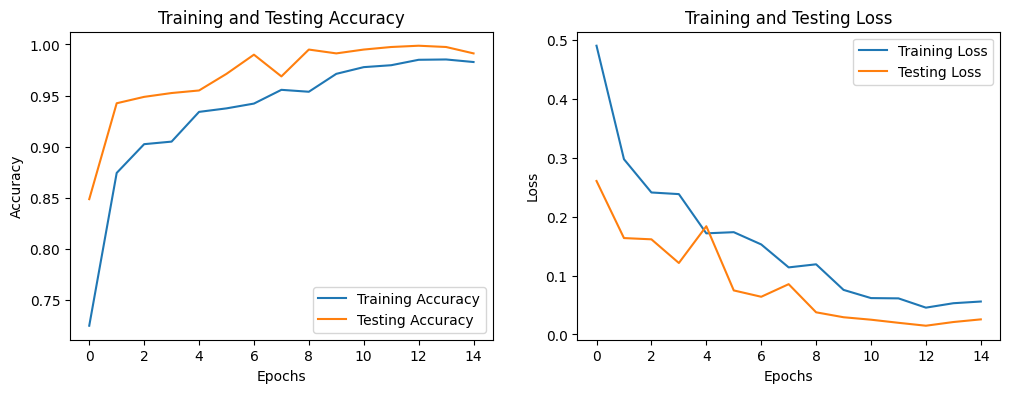

In [18]:

# Display training and testing graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.show()






In [19]:

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = label_encoder.classes_
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=class_names))


25/25 [==============================] - 0s 9ms/step

Classification Report:
               precision    recall  f1-score   support

 Closed_Eyes       0.98      1.00      0.99       422
   Open_Eyes       1.00      0.98      0.99       378

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



100/100 [==============================] - 1s 7ms/step


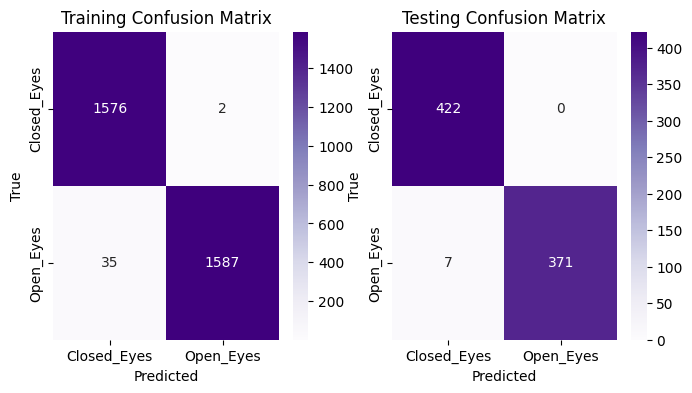

In [20]:
# Confusion matrix for training data
train_predictions = model.predict(X_train)
train_predictions = np.argmax(train_predictions, axis=1)
train_confusion = confusion_matrix(y_train, train_predictions)

# Confusion matrix for testing data
test_confusion = confusion_matrix(y_test, y_pred_classes)

# Display training and testing confusion matrices separately in purple color
plt.figure(figsize=(8, 4))

# Display training confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Display testing confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()


1/1 [==============================] - 0s 78ms/step


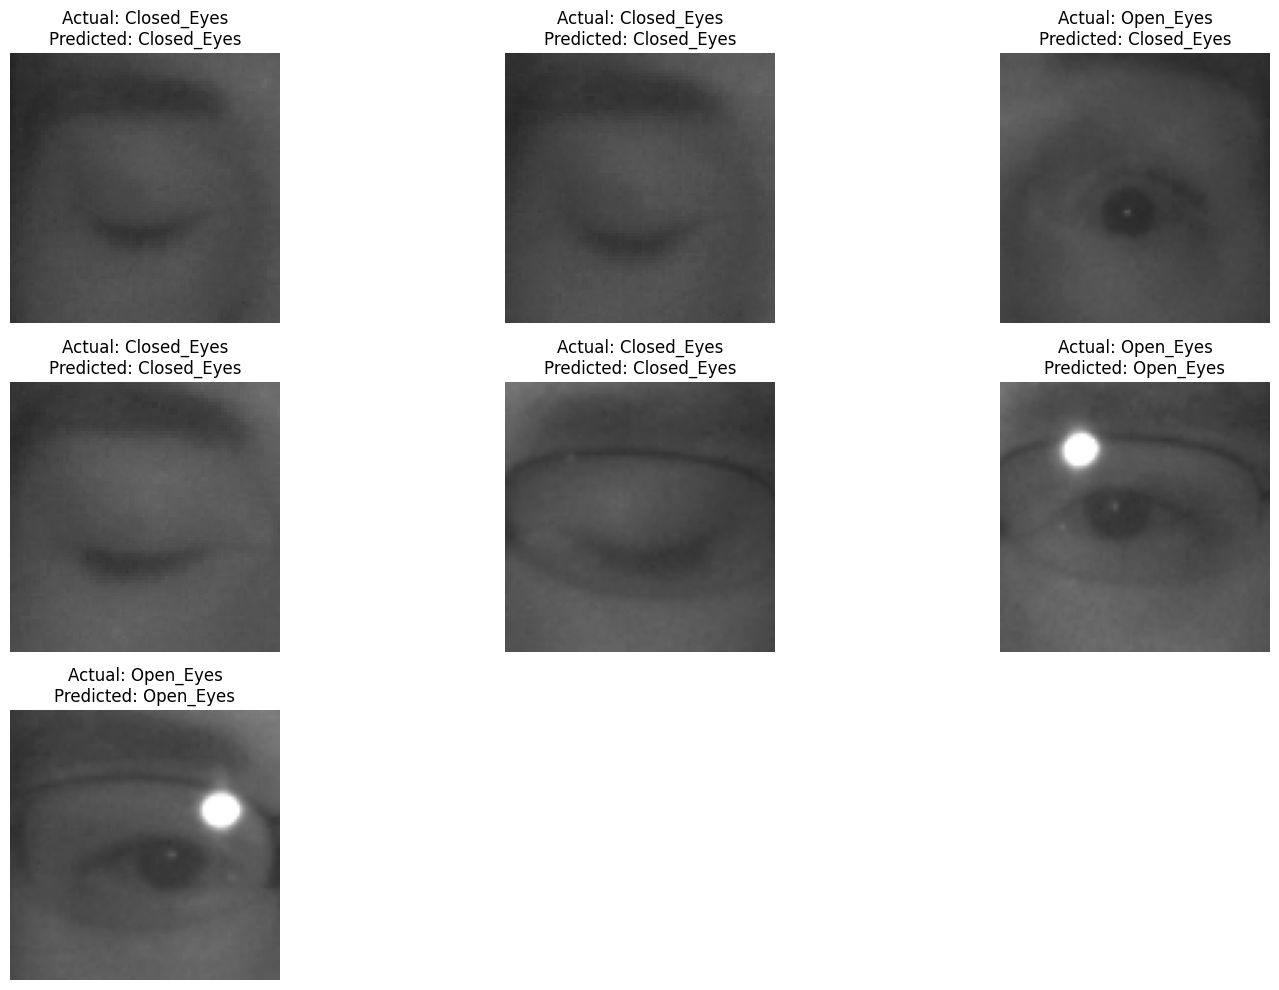

In [21]:
# Load and preprocess images for prediction
prediction_image_paths = [
    '/content/drive/MyDrive/archive (5)/train/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png',
    '/content/drive/MyDrive/archive (5)/train/Closed_Eyes/s0001_00003_0_0_0_0_0_01.png',
    '/content/drive/MyDrive/archive (5)/train/Open_Eyes/s0001_02336_0_0_1_0_0_01.png',
    '/content/drive/MyDrive/archive (5)/train/Closed_Eyes/s0001_00008_0_0_0_0_0_01.png',
    '/content/drive/MyDrive/archive (5)/train/Closed_Eyes/s0001_01569_0_1_0_0_0_01.png',
    '/content/drive/MyDrive/archive (5)/train/Open_Eyes/s0001_02968_0_1_1_2_0_01.png',
    '/content/drive/MyDrive/archive (5)/train/Open_Eyes/s0001_03064_0_1_1_2_0_01.png'
]

# Load and preprocess images for prediction
prediction_images = []
for image_path in prediction_image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize pixel values
    prediction_images.append(img)

# Convert images to a numpy array
prediction_images = np.array(prediction_images)

# Make predictions using the trained model
predictions = model.predict(prediction_images)
predicted_labels = [class_names[i] for i in np.argmax(predictions, axis=1)]

# Define the actual labels for the provided image paths
actual_labels = ['Closed_Eyes', 'Closed_Eyes', 'Open_Eyes', 'Closed_Eyes', 'Closed_Eyes', 'Open_Eyes', 'Open_Eyes']

# Display the images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i in range(len(prediction_image_paths)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(prediction_image_paths[i]), cv2.COLOR_BGR2RGB))
    plt.title(f'Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

